<a href="https://colab.research.google.com/github/rachitpatekar7/Fake-V2X-Detection/blob/main/V2X_Vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the Libraries


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#Encoding and Splitting the Data

In [22]:
# Load the dataset
file_path = "/content/drive/MyDrive/v2x/Updated_Synthetic_V2X_Vehicle_Dataset.csv"  # Replace with your dataset path
v2x_data = pd.read_csv(file_path)

# Identifying categorical columns and encoding them
categorical_cols = v2x_data.select_dtypes(include=['object']).columns

# Encoding all categorical columns with LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for col in categorical_cols:
    v2x_data[col] = label_encoder.fit_transform(v2x_data[col])

# Handling missing values using SimpleImputer (replace NaN with column mean)
imputer = SimpleImputer(strategy='mean')
v2x_data = pd.DataFrame(imputer.fit_transform(v2x_data), columns=v2x_data.columns)

# Prepare features and labels
features = v2x_data.drop(['label'], axis=1)  # Drop label column from features
labels = v2x_data['label'].astype(int)  # Convert labels to binary format

# Split data into labeled and unlabeled for semi-supervised learning
labeled_data, unlabeled_data, labeled_labels, _ = train_test_split(
    features, labels, test_size=0.8, stratify=labels, random_state=42
)


#Training the models


In [23]:
# Self-Training with Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
self_training_lr = SelfTrainingClassifier(logistic_model).fit(labeled_data, labeled_labels)

# Self-Training with SVM
svm_model = SVC(probability=True)
self_training_svm = SelfTrainingClassifier(svm_model).fit(labeled_data, labeled_labels)

# Semi-supervised K-means + Decision Tree
kmeans = KMeans(n_clusters=2, random_state=42).fit(unlabeled_data)
pseudo_labels = kmeans.labels_

# Combine labeled and pseudo-labeled data
combined_features = np.vstack((labeled_data, unlabeled_data))
combined_labels = np.hstack((labeled_labels, pseudo_labels))

# Train Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(combined_features, combined_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


DecisionTreeClassifier(random_state=42)

#Evaluations, Predictions, Metrics

In [24]:
# Evaluation
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Predictions
y_pred_lr = self_training_lr.predict(X_test)
y_pred_svm = self_training_svm.predict(X_test)
y_pred_dt = decision_tree.predict(X_test)

# Metrics
models = ['Logistic Regression', 'SVM', 'Decision Tree']
predictions = [y_pred_lr, y_pred_svm, y_pred_dt]
accuracies = [accuracy_score(y_test, y_pred) for y_pred in predictions]
precisions = [precision_score(y_test, y_pred) for y_pred in predictions]
recalls = [recall_score(y_test, y_pred) for y_pred in predictions]
f1_scores = [f1_score(y_test, y_pred) for y_pred in predictions]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


#Classification Reports

In [25]:
# Print classification reports
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("SVM Report:\n", classification_report(y_test, y_pred_svm))
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.94      0.99      0.97       189

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.89      0.94      0.92       200

SVM Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.94      1.00      0.97       189

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.49       200
weighted avg       0.89      0.94      0.92       200

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.07      0.55      0.13        11
           1       0.96      0.60      0.74       189

    accuracy                           0.60       200
   macro avg       0.52      0.57      0.44       200
weighted 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Confusion Matrices

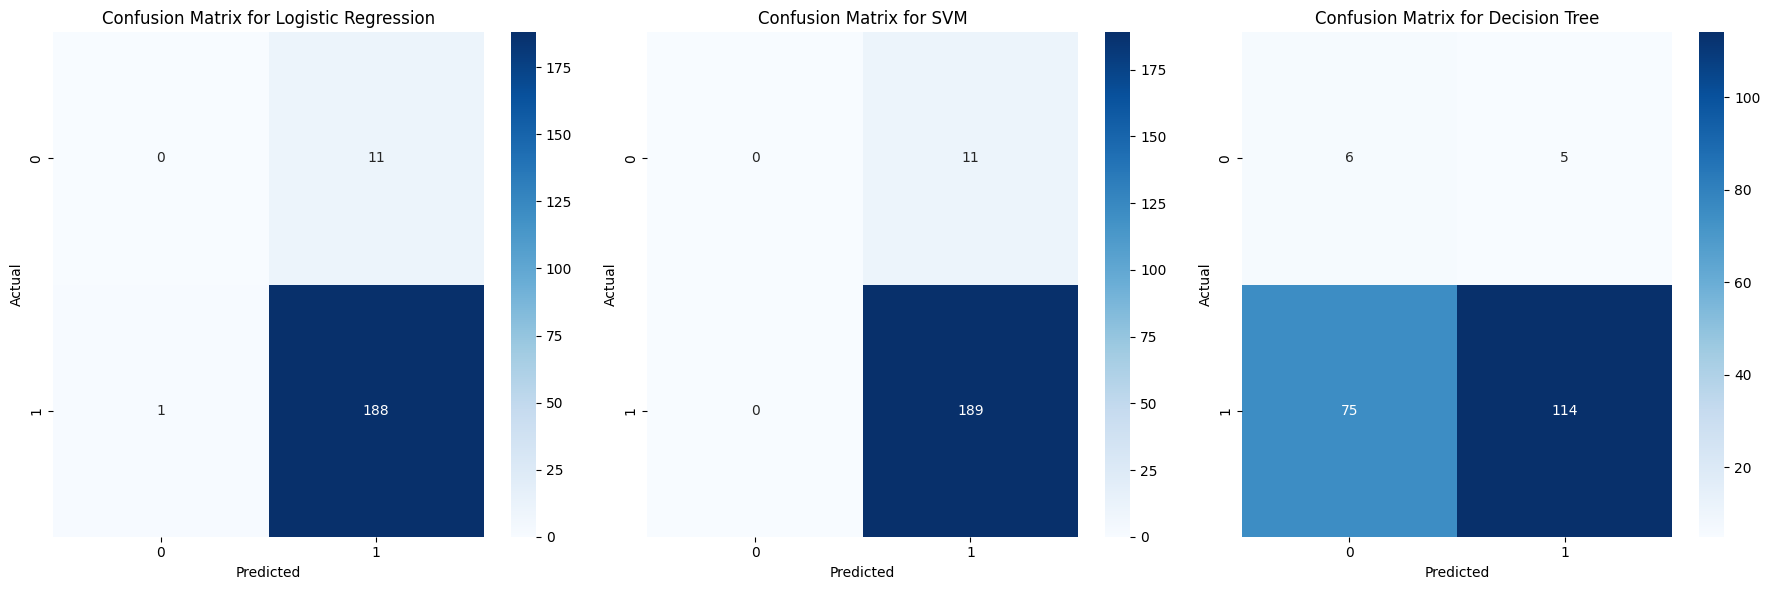

In [26]:
# Confusion Matrices
conf_matrices = [confusion_matrix(y_test, y_pred) for y_pred in predictions]

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (cm, model) in enumerate(zip(conf_matrices, models)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {model}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


#ROC Curves


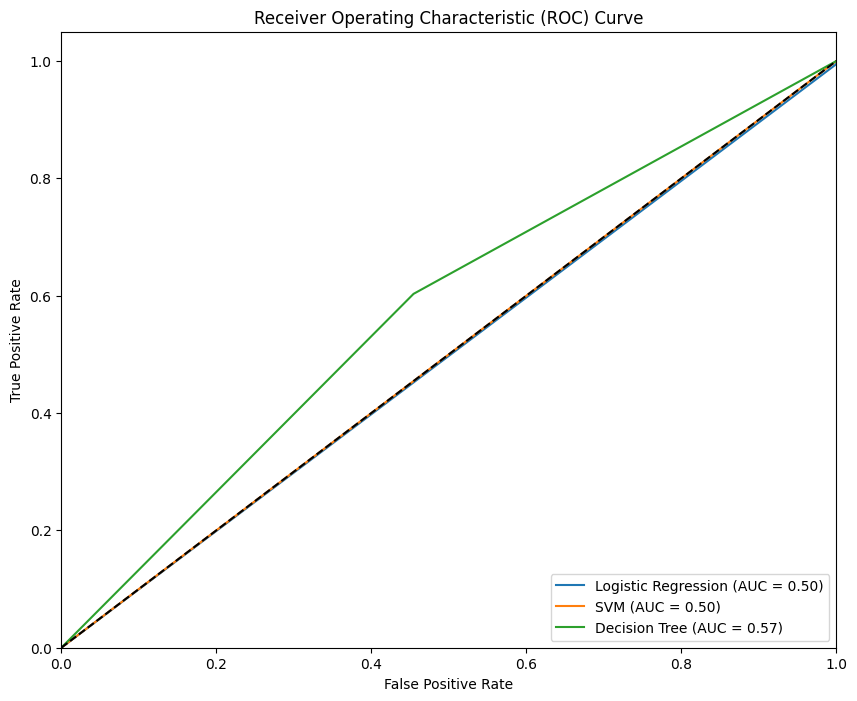

In [27]:
# ROC Curves
plt.figure(figsize=(10, 8))
for i, model in enumerate(models):
    fpr, tpr, _ = roc_curve(y_test, predictions[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#Comparison Chart

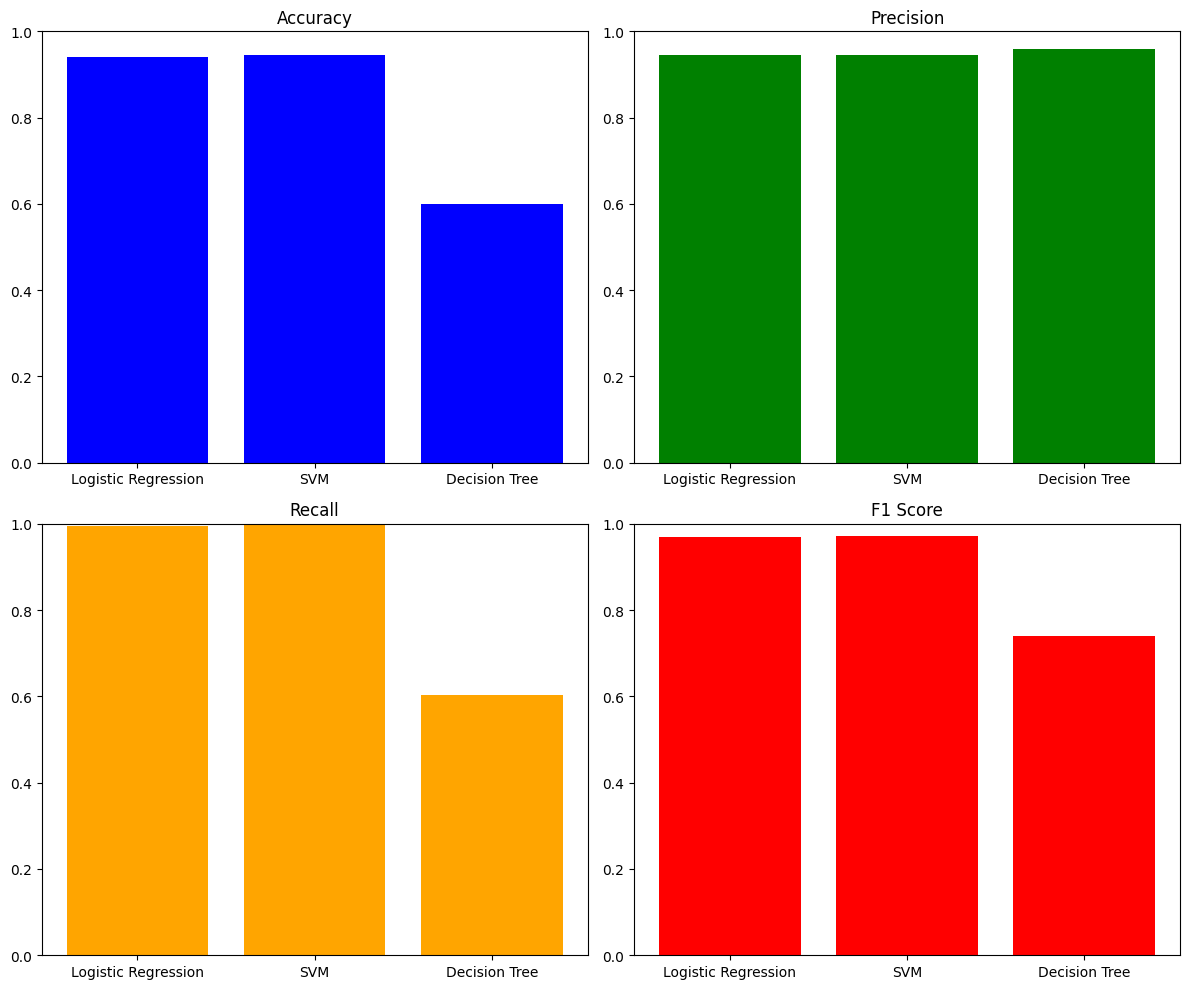

In [28]:
# Comparison Bar Chart
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].bar(models, accuracies, color='blue')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim(0, 1)

ax[0, 1].bar(models, precisions, color='green')
ax[0, 1].set_title('Precision')
ax[0, 1].set_ylim(0, 1)

ax[1, 0].bar(models, recalls, color='orange')
ax[1, 0].set_title('Recall')
ax[1, 0].set_ylim(0, 1)

ax[1, 1].bar(models, f1_scores, color='red')
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()